In [ ]:
# The first time you're running this, install the required packages using the code below
install.packages(c("tidyverse", "quanteda", "igraph", "topicmodels"))

In [4]:
library(tidyverse)
tweets = read_csv("http://cssbook.net/d/covid.csv") 
head(tweets)

Parsed with column specification:
cols(
  status_id = col_double(),
  screen_name = col_character(),
  lang = col_character(),
  location = col_character(),
  text = col_character(),
  retweet_count = col_double(),
  reply_to_screen_name = col_character()
)



status_id,screen_name,lang,location,text,retweet_count,reply_to_screen_name
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1.309536e+18,ghulamabbasshah,en,"Lahore, Pakistan",Secularism of #Gandhi and #Nehru in #India has been replaced by #RSS #Hindutva . #Muslims falsely blame &amp; victimized for spreading #covid #RSS is an organisation that promotes #Islamophobia India is the only country that witnessed state sponsored Islamophobia. says #ImranKhan https://t.co/HZZEgvBzyW,1203,NA
1.309626e+18,GeoRebekah,en,"Florida, USA","On the day @GovRonDeSantis rejects the experts and all reason by forcing Florida into Phase III, a 12 year old girl from Atlantic Beach lost her battle with #COVID and died. She was in the sixth grade. Just started school back to at Mayport in Duval. #ThisIsThePrice",1146,NA
1.309578e+18,AlexBerenson,en,New York,"Updated @cgcgov figures: 66 children under 15 have died from/with #Covid since February. 16,761 have died of other causes. Fewer than 1 in 250 child deaths are related to #Covid in any way. https://t.co/lGT3osyDOg",988,NA
1.309558e+18,AlexBerenson,en,New York,No mo ro in Flo: @govrondesantis proves again he gets the science and is the best big-state governor on #Covid by not just lifting all restrictions but stopping cities and counties from enforcing their own nonsense. Say it with me: WAAAAIT TWO WEEKS! https://t.co/E4BMxtdIT8,953,NA
1.309643e+18,B52Malmet,en,"New York, NY","Dr. Fauci warns the worst public health crisis in our lifetime is not what we are going through now, but what is coming in the fall and winter. Keep your laser focus on staying safe, masking up, preparing for #covid winter. Stay strong. Stay well. Only 1st🦵of a marathon.",946,NA
1.309772e+18,iingwen,en,Taipei City,It’s great to have a genuine friend like #Nauru! Thank you President Aingimea for speaking up for #Taiwan’s rights at #UN75 &amp; telling the world about what we have to offer when it comes to responding to global issues like #COVID. https://t.co/lLb90TiCKH,436,NA


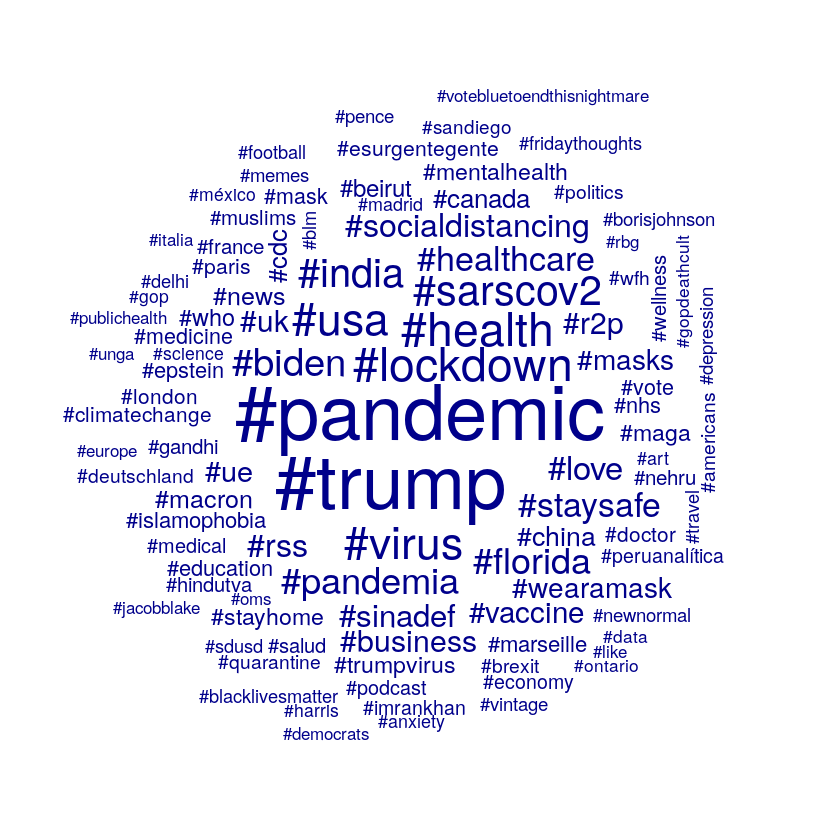

In [13]:
library(quanteda)
dfm(tweets$text, tolower = T, remove=stopwords('en'), remove_punct=T) %>% 
  dfm_select(pattern = "#*") %>% 
  dfm_remove(c("#corona*", "#covid*")) %>% 
  textplot_wordcloud(max_words=100)

In [15]:
library(topicmodels)
set.seed(123)
m = convert(hashtags, to="topicmodel")  %>% LDA(10)
terms(m, 5)

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
#florida,#trump,#love,#lockdown,#pandemic,#vaccine,#sarscov2,#canada,#marseille,#staysafe
#pandemia,#usa,#mentalhealth,#india,#healthcare,#vote,#virus,#trumpvirus,#paris,#socialdistancing
#sinadef,#biden,#health,#rss,#health,#maga,#brexit,#trump,#france,#nhs
#esurgentegente,#uk,#wellness,#wearamask,#china,#podcast,#students,#who,#deluca,#wfh
#peruanalítica,#r2p,#depression,#islamophobia,#medicine,#politics,#deutschland,#americans,#nancypelosi,#cdc


In [18]:
edges = tweets %>% 
  select(from=screen_name, to=reply_to_screen_name) %>% 
  filter(to != "") %>%
  group_by(to, from) %>% 
  summarize(n=n())
head(edges)

`summarise()` regrouping output by 'to' (override with `.groups` argument)



to,from,n
<chr>,<chr>,<int>
_FutureIsUs,_FutureIsUs,1
_JaylaS_,AfronerdRadio,1
_LoveMTB_,ExpatriateNl,1
_nogueiraneto,ideobisium,1
_NotFakeNews_,panich52,1
_vikasupadhyay,SHADABMOHAMMAD7,4


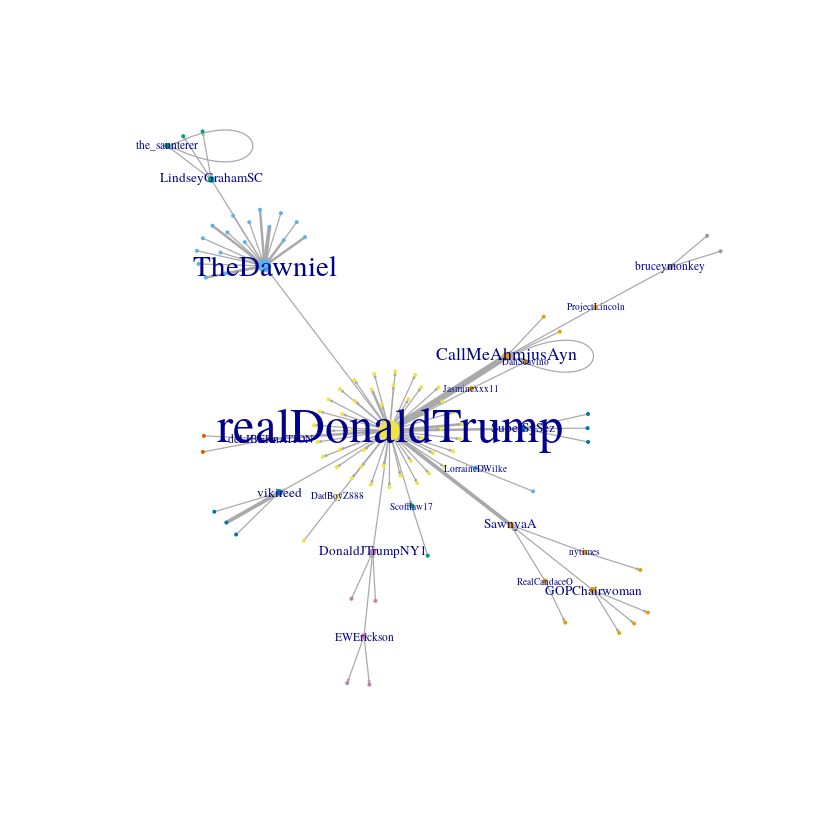

In [21]:
library(igraph)
# create igraph network and select largest component
g = graph_from_data_frame(edges)
components <- decompose.graph(g)
g2 = components[[which.max(sapply(components, gsize))]]
# Color nodes by cluster
clusters = cluster_spinglass(g2)
V(g2)$color = clusters$membership
V(g2)$frame.color = V(g2)$color
# Set node (user) and edge (arrow) size
V(g2)$size = degree(g2)^.5
V(g2)$label.cex = V(g2)$size/3
V(g2)$label = ifelse(degree(g2)<=1, "", V(g2)$name) 
E(g2)$width = E(g2)$n
E(g2)$arrow.size= E(g2)$width/10
plot(g2)

Parsed with column specification:
cols(
  screen_name = col_character(),
  location = col_character(),
  lat = col_double(),
  long = col_double()
)

Joining, by = c("screen_name", "location", "lat", "long")

Warning message:
“Removed 3371 rows containing missing values (geom_point).”


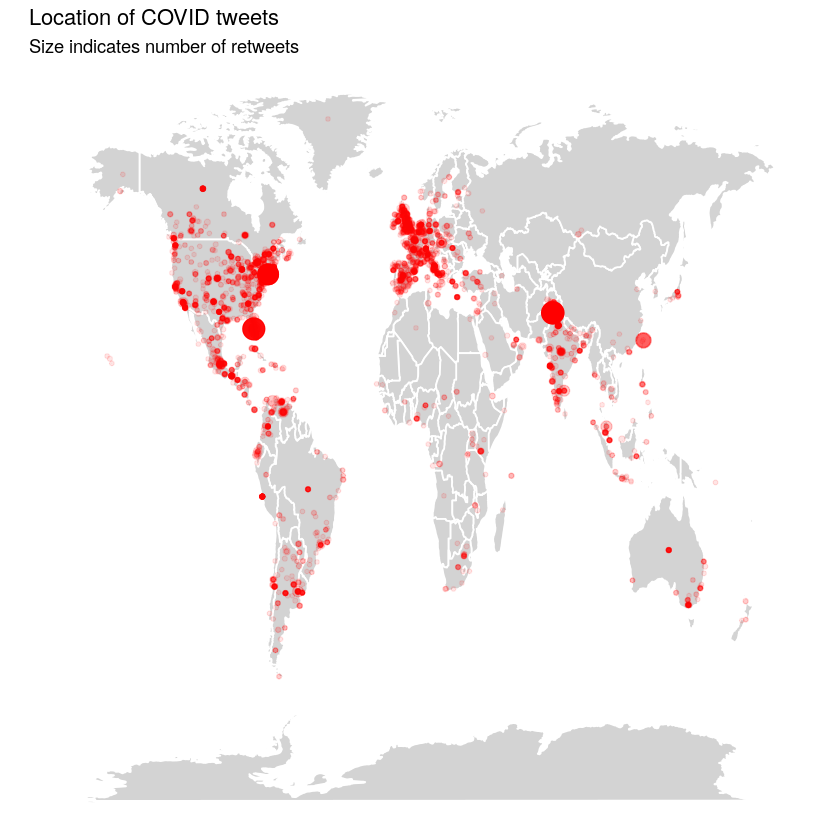

In [26]:
users = read_csv("http://cssbook.net/d/covid_users.csv")
tweets = left_join(tweets, users)
ggplot(mapping=aes(x = long, y = lat)) +
  geom_polygon(aes(group=group), data=map_data('world'), fill="lightgray", colour = "white") +
  geom_point(aes(size=retweet_count, alpha=retweet_count), data=tweets, color='red') + 
  theme_void() + theme(aspect.ratio=1) + guides(alpha=FALSE, size=FALSE) + 
  ggtitle("Location of COVID tweets", "Size indicates number of retweets")


In [28]:
edges2 = edges %>% 
  inner_join(users, by=c("from"="screen_name")) %>% 
  inner_join(users, by=c("to"="screen_name"), suffix=c("", ".to")) %>% 
  filter(lat != lat.to | long != long.to )
head(edges2)

to,from,n,location,lat,long,location.to,lat.to,long.to
<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
_NotFakeNews_,panich52,1,SW PA,10.42263,-2.805897,"Pittsburgh, PA",40.44169,-79.9900861
983FLYFM,KFFBS,1,"Kingston Frontenac, Ontario",44.18215,-76.462706,"Kingston, Ontario, Canada",44.23069,-76.4813230
abcpoppins,DalbidEU,1,Lancashire and Europe,54.05673,-2.837250,"South West, England",52.79548,-0.5402403
Agenzia_Italia,V_Mannello,1,Italia,42.63843,12.674297,"Roma, Lazio",41.88524,12.4206550
AlexG6,antwigan,1,NW UK,58.96616,5.727150,"Wigan, England",53.54572,-2.6264624
AlistairHaimes,PleaseDoTheMath,1,UK,54.70235,-3.276575,"Bristol, England",51.45380,-2.5972985


Warning message:
“Removed 3371 rows containing missing values (geom_point).”


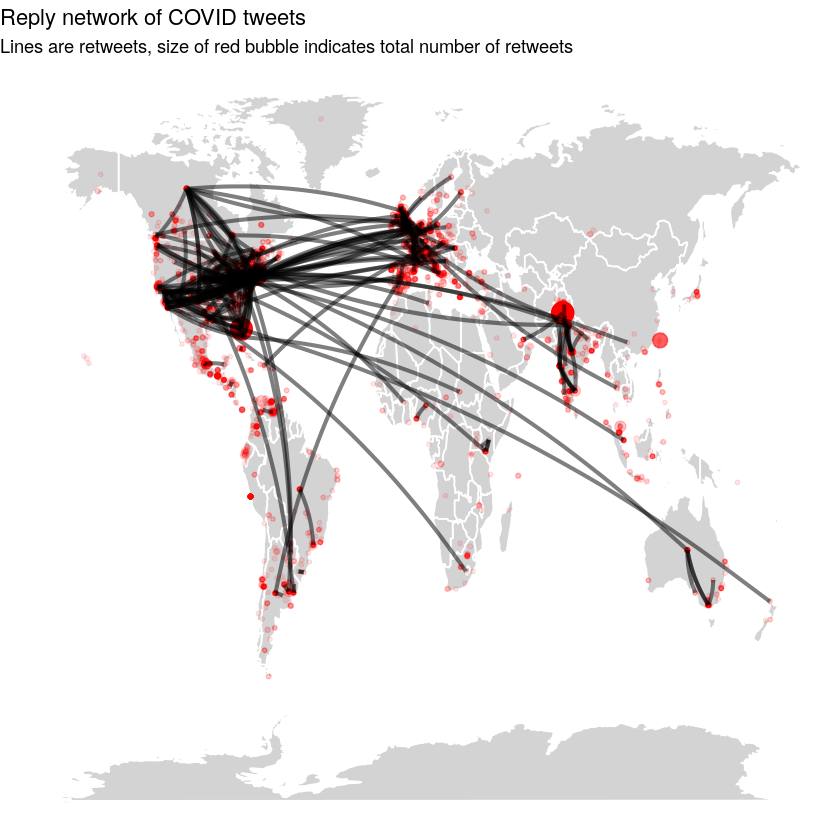

In [30]:
# Plot network on the map
ggplot(mapping=aes(x = long, y = lat)) +
  geom_polygon(aes(group=group), map_data('world'), fill="lightgray", colour = "white") +
  geom_point(aes(size=retweet_count, alpha=retweet_count), data=tweets, color='red') + 
  geom_curve(aes(xend=long.to, yend=lat.to, size=n), edges2, curvature=.1, alpha=.5) +
  theme_void() + guides(alpha=FALSE, size=FALSE) + 
  ggtitle("Reply network of COVID tweets", "Lines are retweets, size of red bubble indicates total number of retweets")

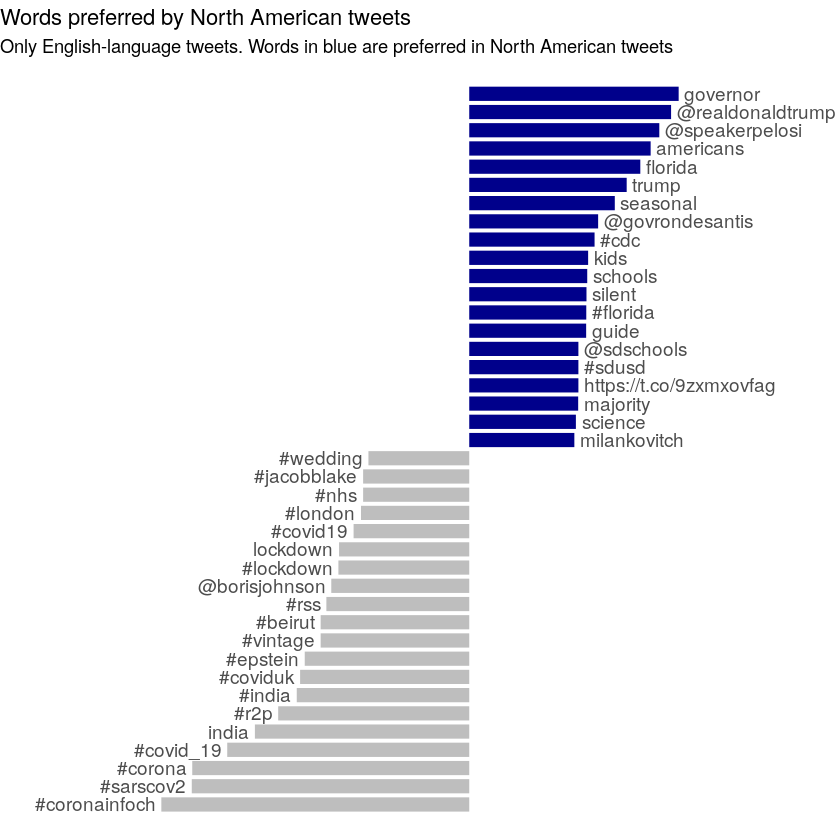

In [32]:
tweets = tweets %>% mutate(northamerica=ifelse(long < -60 & lat > 25, "North America", "Rest"))
dfm = filter(tweets, lang=='en') %>% 
  corpus(docid_field="status_id") %>% 
  dfm(tolower = T, groups="northamerica", remove=stopwords('en'), remove_punct=T) %>% 
  dfm_select(min_nchar=4)
textstat_keyness(dfm, target="North America") %>% 
  textplot_keyness(show_legend=FALSE, margin=0.2) +
  ggtitle("Words preferred by North American tweets", "Only English-language tweets. Words in blue are preferred in North American tweets") + theme_void()


In [40]:
# Getting location data
library(tmaptools)
geocode_OSM(c("Amsterdam", "New York"))

query,lat,lon,lat_min,lat_max,lon_min,lon_max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Amsterdam,52.37454,4.897976,52.27817,52.43106,4.728756,5.079162
New York,40.71273,-74.006015,40.47740,40.91618,-74.259090,-73.700181


In [42]:
# Using twitter to get tweets and user info
library(rtweet)
lookup_users("vanatteveldt")  %>% select("user_id", "screen_name", "location")


user_id,screen_name,location
<chr>,<chr>,<chr>
155724548,vanatteveldt,Amsterdam


In [46]:
search_tweets("@vanatteveldt") %>% select(screen_name, created_at, text)

screen_name,created_at,text
<chr>,<dttm>,<chr>
scott_althaus,2020-09-28 17:48:03,"@KasperWelbers @vanatteveldt You would think, right? As for me, despite the threat to life and limb I plan on continuing my black licorice habit (in moderation, of course!)"
scott_althaus,2020-09-24 20:24:51,"To my Amsterdam friends @vanatteveldt and @KasperWelbers, is this news story splashed across every screen right now in your fair city? Or was the Dutch population already aware of the health hazards involved in black licorice eating? https://t.co/bYsJjxs7cP"
KasperWelbers,2020-09-27 20:02:28,"@scott_althaus @vanatteveldt This is completely new to me! My theory is that due to natural selection, there are no people left in the Netherlands for whom this warning would have been relevant."
rosaborgeb,2020-09-27 17:31:01,My new articles in Communication Methods &amp; Measures - Reproducible Extraction of Cross-lingual Topics using #rstats (rectr) with @Meg_Zeng @hwessler @MarcCWJ @KasperWelbers Joe Bajjalieh @vanatteveldt @scott_althaus For @ResTeCo project https://t.co/fRxdhKzTYm https://t.co/fi3Iwfk8Cc
mwojcieszak,2020-09-25 17:44:19,@judith_moeller @MattisNicolas @vanatteveldt love 😄
LindaBos80,2020-09-25 11:54:04,@judith_moeller @MattisNicolas @vanatteveldt Haha!
judith_moeller,2020-09-25 11:32:50,This supervision meeting took a strange turn. Thanks for making my day @MattisNicolas and @vanatteveldt https://t.co/eZOJhZYsWJ


In [ ]:
tweets = search_tweets("#covid", n = 10000, include_rts = FALSE) 
tweets = tweets %>% select(status_id, screen_name, lang, location, text, retweet_count, reply_to_screen_name) %>% 
  arrange(-retweet_count)

In [ ]:
replied_users = setdiff(tweets$reply_to_screen_name, tweets$screen_name) %>% na.omit()
# Use the Twitter API to get their locations
users = lookup_users(replied_users) %>% select(screen_name, location) 
# Combine with existing users, filter blank locations and duplicate names, and clean location names
users = tweets %>% select(screen_name, location) %>%
  bind_rows(users) %>% 
  unique() %>%
  filter(location != "") %>% 
  mutate(location = str_replace_all(location, "[^\\p{L} ,/-]+", " "))
head(users)

# Use Open Street Map API to "geocode" the locations and merge back with users
locations = geocode_OSM(unique(users$location)) %>% 
  select(location=query, lat, long=lon)
users = users %>% left_join(locations)